<a href="https://colab.research.google.com/github/avirooppal/RealTimeStock/blob/main/RealTimeStockModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
pip install numpy pandas matplotlib scikit-learn keras tensorflow

In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [24]:


# Fetch historical stock data
def fetch_stock_data(ticker, period="1y", interval="1d"):
    stock_data = yf.download(ticker, period=period, interval=interval)
    return stock_data

# Example: Fetch 1-year daily data for Apple
data = fetch_stock_data("AAPL")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Date                                                                        
2023-11-02 00:00:00+00:00  176.666000  177.570007  177.779999  175.460007   
2023-11-03 00:00:00+00:00  175.750656  176.649994  176.820007  173.350006   
2023-11-06 00:00:00+00:00  178.317520  179.229996  179.429993  176.210007   
2023-11-07 00:00:00+00:00  180.894348  181.820007  182.440002  178.970001   
2023-11-08 00:00:00+00:00  181.958908  182.889999  183.449997  181.589996   

Price                            Open    Volume  
Ticker                           AAPL      AAPL  
Date                                             
2023-11-02 00:00:00+00:00  175.520004  77334800  
2023-11-03 00:00:00+00:00  174.240005  79763700  
2023-11-06 00:00:00+00:00  176.380005  63841300  
2023-11-07 00:00:00+00:00  179.179993  70530000  
2023-11-08 00:00:00+00:00  182.35

In [25]:
# Step 2: Data Preprocessing
def preprocess_data(data):
    # Select the 'Close' price only
    data = data[['Close']].dropna()  # Remove NaNs
    data = data.values  # Convert to numpy array for easy manipulation

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Preprocess data
scaled_data, scaler = preprocess_data(data)

# Step 3: Create features and target variable
def create_features(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Prepare data
window_size = 60  # Use last 60 days for prediction
X, y = create_features(scaled_data, window_size)


In [26]:
# Step 4: Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [27]:
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.2083 - val_loss: 0.0699
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0263 - val_loss: 0.0423
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0279 - val_loss: 0.0185
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0190 - val_loss: 0.0354
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0178 - val_loss: 0.0042
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0122 - val_loss: 0.0073
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0142 - val_loss: 0.0042
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0096 - val_loss: 0.0063
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0110 - val_loss: 0.0037
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0109 - val_loss: 0.0041
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0105 - val_loss: 0.0037
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0098 - val_loss: 0.0

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step


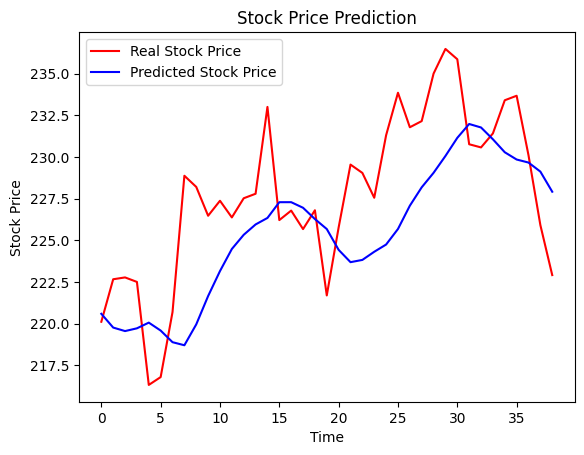

In [29]:

# Make predictions on the test set
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)  # Inverse scaling

# Inverse scaling of actual test data
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.plot(real_stock_price, color="red", label="Real Stock Price")
plt.plot(predicted_stock_price, color="blue", label="Predicted Stock Price")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [33]:
def predict_next_price(model, recent_data, scaler):
    # Get the actual name of the price column from recent_data.columns
    price_column_name = recent_data.columns[0]  # Assuming price is the first column

    # Continue with the rest of the prediction logic
    recent_data_feature = recent_data[[price_column_name]]
    recent_data_scaled = scaler.transform(recent_data_feature)
    X_recent = np.reshape(recent_data_scaled, (1, recent_data_scaled.shape[0], 1))
    predicted_price_scaled = model.predict(X_recent)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    return predicted_price[0, 0]

# Get the last 60 days of data for prediction
recent_data = data[-window_size:]
next_day_prediction = predict_next_price(model, recent_data, scaler)
print("Predicted Stock Price for Next Day:", next_day_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Stock Price for Next Day: 226.1561


In [34]:
model.save('stock_price_prediction_model.h5')